In [2]:
pip install tab-transformer-pytorch


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV , KFold , cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import log_loss ,classification_report, f1_score, accuracy_score , make_scorer

# DL
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("/Users/anand/Desktop/FAI/Data file/balanced_final_preprocessed_df.csv")
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],NF,HDA,OF,PF,RF,TWF,Target
0,1,0.304348,0.358025,0.131389,0.535714,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0
1,0,0.315217,0.370370,0.098334,0.583791,0.011858,1.0,0.0,0.0,0.0,0.0,0.0,0
2,0,0.304348,0.345679,0.120623,0.626374,0.019763,1.0,0.0,0.0,0.0,0.0,0.0,0
3,0,0.315217,0.358025,0.105099,0.490385,0.027668,1.0,0.0,0.0,0.0,0.0,0.0,0
4,0,0.315217,0.370370,0.098334,0.497253,0.035573,1.0,0.0,0.0,0.0,0.0,0.0,0


In [5]:
df.columns

Index(['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'NF', 'HDA',
       'OF', 'PF', 'RF', 'TWF', 'Target'],
      dtype='object')

In [26]:
X = df[['Type', 'Air temperature [K]', 'Process temperature [K]',
        'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']].copy()

# Rename columns to remove invalid characters
X.columns = ['Type', 'Air_temp_K', 'Process_temp_K', 'Rot_speed_rpm', 'Torque_Nm', 'Tool_wear_min']


In [27]:
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],NF,HDA,OF,PF,RF,TWF,Target
0,1,0.304348,0.358025,0.131389,0.535714,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0
1,0,0.315217,0.370370,0.098334,0.583791,0.011858,1.0,0.0,0.0,0.0,0.0,0.0,0
2,0,0.304348,0.345679,0.120623,0.626374,0.019763,1.0,0.0,0.0,0.0,0.0,0.0,0
3,0,0.315217,0.358025,0.105099,0.490385,0.027668,1.0,0.0,0.0,0.0,0.0,0.0,0
4,0,0.315217,0.370370,0.098334,0.497253,0.035573,1.0,0.0,0.0,0.0,0.0,0.0,0


In [28]:
# -------------------------------
# 2️⃣ Dataset Preparation
# -------------------------------
# Safe column names for XGBoost
X = df[['Type', 'Air temperature [K]', 'Process temperature [K]',
        'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']].copy()
X.columns = ['Type', 'Air_temp_K', 'Process_temp_K', 'Rot_speed_rpm', 'Torque_Nm', 'Tool_wear_min']

# Targets: Target + failure types
y = df[['Target', 'HDA', 'OF', 'PF', 'RF', 'TWF']].copy()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['Target']
)

In [29]:
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],NF,HDA,OF,PF,RF,TWF,Target
0,1,0.304348,0.358025,0.131389,0.535714,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0
1,0,0.315217,0.370370,0.098334,0.583791,0.011858,1.0,0.0,0.0,0.0,0.0,0.0,0
2,0,0.304348,0.345679,0.120623,0.626374,0.019763,1.0,0.0,0.0,0.0,0.0,0.0,0
3,0,0.315217,0.358025,0.105099,0.490385,0.027668,1.0,0.0,0.0,0.0,0.0,0.0,0
4,0,0.315217,0.370370,0.098334,0.497253,0.035573,1.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (12800, 6)
X_test shape: (3200, 6)
y_train shape: (12800, 6)
y_test shape: (3200, 6)


In [10]:
# -------------------------------
# 3️⃣ Base ML Models
# -------------------------------
base_models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "SVC": SVC(probability=True, random_state=42)
}


In [11]:
multi_models = {name: MultiOutputClassifier(model) for name, model in base_models.items()}

# -------------------------------
# 4️⃣ Train & Evaluate Base Models
# -------------------------------
results = []
for name, model in multi_models.items():
    print(f"--- Training {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Compute accuracy & macro F1
    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    
    results.append({'Model': name, 'Accuracy': acc, 'MacroF1': macro_f1})
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {acc:.4f} | Macro F1: {macro_f1:.4f}\n")

# Convert results to DataFrame for visualization
results_df = pd.DataFrame(results).sort_values(by='MacroF1', ascending=False)
print("Base model results:\n", results_df)


--- Training RandomForest ---
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1200
           1       0.92      0.93      0.92       241
           2       0.92      0.92      0.92       236
           3       0.91      0.91      0.91       221
           4       0.97      0.90      0.93       268
           5       0.89      0.93      0.91       234

   micro avg       0.91      0.93      0.92      2400
   macro avg       0.92      0.92      0.92      2400
weighted avg       0.91      0.93      0.92      2400
 samples avg       0.35      0.35      0.35      2400

Accuracy: 0.9322 | Macro F1: 0.9190

--- Training AdaBoost ---
              precision    recall  f1-score   support

           0       0.77      0.68      0.72      1200
           1       0.91      0.94      0.93       241
           2       0.79      0.92      0.85       236
           3       0.90      0.90      0.90       221
           4       0.49      0.07      

In [1]:
# Multi-output target
y_multi = df[['HDA','OF','PF','RF','TWF']]  # multi-output target

# Features
X_features = X  # already selected features

# Top 3 models
base_models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

multi_models = {name: MultiOutputClassifier(model) for name, model in base_models.items()}

# CV splits
cv = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for name, model in multi_models.items():
    train_scores = []
    val_scores = []
    
    for train_idx, val_idx in cv.split(X_features):
        X_tr, X_val = X_features.iloc[train_idx], X_features.iloc[val_idx]
        y_tr, y_val = y_multi.iloc[train_idx], y_multi.iloc[val_idx]
        
        model.fit(X_tr, y_tr)
        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)
        
        train_scores.append(f1_score(y_tr, y_tr_pred, average='macro'))
        val_scores.append(f1_score(y_val, y_val_pred, average='macro'))
    
    results[name] = {
        "Train Macro F1": np.mean(train_scores),
        "Train Std": np.std(train_scores),
        "Validation Macro F1": np.mean(val_scores),
        "Validation Std": np.std(val_scores)
    }

# Convert to DataFrame
df_results = pd.DataFrame(results).T

# Plot
plt.figure(figsize=(10,6))
bar_width = 0.35
index = np.arange(len(df_results))

plt.bar(index, df_results['Train Macro F1'], bar_width, label='Train Macro F1', alpha=0.7)
plt.bar(index + bar_width, df_results['Validation Macro F1'], bar_width, label='Validation Macro F1', alpha=0.7)

plt.errorbar(index, df_results['Train Macro F1'], yerr=df_results['Train Std'], fmt='none', ecolor='black', capsize=5)
plt.errorbar(index + bar_width, df_results['Validation Macro F1'], yerr=df_results['Validation Std'], fmt='none', ecolor='black', capsize=5)

plt.xticks(index + bar_width/2, df_results.index)
plt.ylabel('Macro F1 Score')
plt.title('Train vs Validation Macro F1 for Multi-Output Models')
plt.ylim(0,1.05)
plt.legend()
plt.show()


NameError: name 'df' is not defined

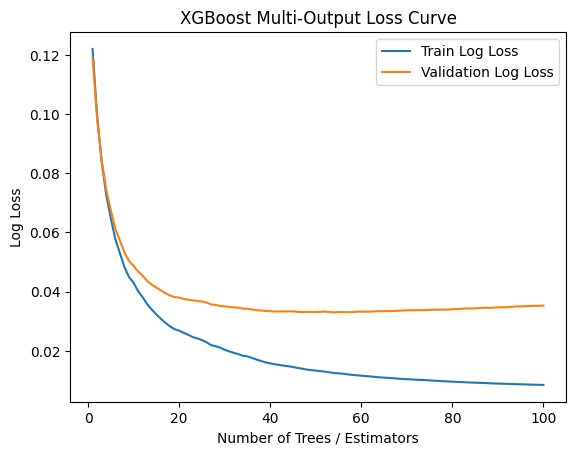

In [14]:
# Train/val split
X_tr, X_val, y_tr, y_val = train_test_split(X_features, y_multi, test_size=0.2, random_state=42)

# Wrap multi-output
xgb_model = MultiOutputClassifier(XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42))

# Lists to store losses
train_losses = []
val_losses = []

for i in range(1, 101):  # 100 boosting rounds
    xgb_model.estimators_ = None  # reset
    xgb_model.set_params(estimator__n_estimators=i)
    xgb_model.fit(X_tr, y_tr)
    
    y_tr_pred = np.array([est.predict_proba(X_tr) for est in xgb_model.estimators_])
    y_val_pred = np.array([est.predict_proba(X_val) for est in xgb_model.estimators_])
    
    # Compute average log loss across outputs
    tr_loss = np.mean([log_loss(y_tr.iloc[:, j], y_tr_pred[j]) for j in range(y_tr.shape[1])])
    val_loss = np.mean([log_loss(y_val.iloc[:, j], y_val_pred[j]) for j in range(y_val.shape[1])])
    
    train_losses.append(tr_loss)
    val_losses.append(val_loss)

# Plot
plt.plot(range(1,101), train_losses, label='Train Log Loss')
plt.plot(range(1,101), val_losses, label='Validation Log Loss')
plt.xlabel('Number of Trees / Estimators')
plt.ylabel('Log Loss')
plt.title('XGBoost Multi-Output Loss Curve')
plt.legend()
plt.show()

In [15]:
print(train_losses[:5], val_losses[:5])  # Print first 5 losses for brevity

[0.12200136497565786, 0.09940186434949891, 0.08391195633416791, 0.07262046585417846, 0.0648453691851781] [0.11902542583202402, 0.09848711466532047, 0.08433565229889345, 0.07447042416961987, 0.06748968824719716]


In [16]:
pip install --upgrade xgboost


Note: you may need to restart the kernel to use updated packages.


In [33]:

# -------------------------------
# 1️⃣ Prepare storage for models and losses
# -------------------------------
rf_models, xgb_models, cat_models = [], [], []

rf_train_loss, rf_val_loss = [], []
xgb_train_loss, xgb_val_loss = [], []
cat_train_loss, cat_val_loss = [], []

# -------------------------------
# 2️⃣ Random Forest
# -------------------------------
rf_preds_val = []

for i in range(y_train.shape[1]):
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    rf.fit(X_train, y_train.iloc[:, i])
    rf_models.append(rf)
    
    # Predictions
    tr_pred = rf.predict_proba(X_train)[:,1]
    val_pred = rf.predict_proba(X_val)[:,1]
    
    # Log Loss
    rf_train_loss.append(log_loss(y_train.iloc[:, i], tr_pred))
    rf_val_loss.append(log_loss(y_val.iloc[:, i], val_pred))
    
    # Store validation predictions for metrics
    rf_preds_val.append(rf.predict(X_val))

rf_preds_val = np.column_stack(rf_preds_val)
rf_acc = accuracy_score(y_val, rf_preds_val)
rf_macro_f1 = f1_score(y_val, rf_preds_val, average='macro')
print(f"RandomForest - Accuracy: {rf_acc:.4f}, MacroF1: {rf_macro_f1:.4f}")

# -------------------------------
# 3️⃣ XGBoost
# -------------------------------
for i in range(y_train.shape[1]):
    xgb = XGBClassifier(
        n_estimators=300,        # lower to prevent overfitting
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,           # L1 regularization
        reg_lambda=1.0,          # L2 regularization
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    )
    xgb.fit(X_train, y_train.iloc[:, i], verbose=False)
    xgb_models.append(xgb)
    
    # Predictions
    tr_pred = xgb.predict_proba(X_train)[:,1]
    val_pred = xgb.predict_proba(X_val)[:,1]
    
    # Log Loss
    xgb_train_loss.append(log_loss(y_train.iloc[:, i], tr_pred))
    xgb_val_loss.append(log_loss(y_val.iloc[:, i], val_pred))

xgb_preds_val = np.column_stack([m.predict(X_val) for m in xgb_models])
xgb_acc = accuracy_score(y_val, xgb_preds_val)
xgb_macro_f1 = f1_score(y_val, xgb_preds_val, average='macro')
print(f"XGBoost - Accuracy: {xgb_acc:.4f}, MacroF1: {xgb_macro_f1:.4f}")

# -------------------------------
# 4️⃣ CatBoost
# -------------------------------
for i in range(y_train.shape[1]):
    cat = CatBoostClassifier(
        iterations=300,
        depth=5,
        learning_rate=0.05,
        l2_leaf_reg=3,          # L2 regularization
        subsample=0.8,
        eval_metric='Logloss',
        random_seed=42,
        verbose=0
    )
    cat.fit(X_train, y_train.iloc[:, i])
    cat_models.append(cat)
    
    # Predictions
    tr_pred = cat.predict_proba(X_train)[:,1]
    val_pred = cat.predict_proba(X_val)[:,1]
    
    # Log Loss
    cat_train_loss.append(log_loss(y_train.iloc[:, i], tr_pred))
    cat_val_loss.append(log_loss(y_val.iloc[:, i], val_pred))

cat_preds_val = np.column_stack([m.predict(X_val) for m in cat_models])
cat_acc = accuracy_score(y_val, cat_preds_val)
cat_macro_f1 = f1_score(y_val, cat_preds_val, average='macro')
print(f"CatBoost - Accuracy: {cat_acc:.4f}, MacroF1: {cat_macro_f1:.4f}")

# -------------------------------
# 5️⃣ Plot Train vs Validation Loss
# -------------------------------
plt.figure(figsize=(12,6))
plt.plot(rf_train_loss, label='RF Train Loss', marker='o')
plt.plot(rf_val_loss, label='RF Val Loss', marker='o')
plt.plot(xgb_train_loss, label='XGB Train Loss', marker='x')
plt.plot(xgb_val_loss, label='XGB Val Loss', marker='x')
plt.plot(cat_train_loss, label='Cat Train Loss', marker='s')
plt.plot(cat_val_loss, label='Cat Val Loss', marker='s')
plt.xlabel('Output Label Index')
plt.ylabel('Log Loss')
plt.title('Train vs Validation Loss (Top 3 Models with Regularization)')
plt.legend()
plt.grid(True)
plt.show()


IndexError: single positional indexer is out-of-bounds

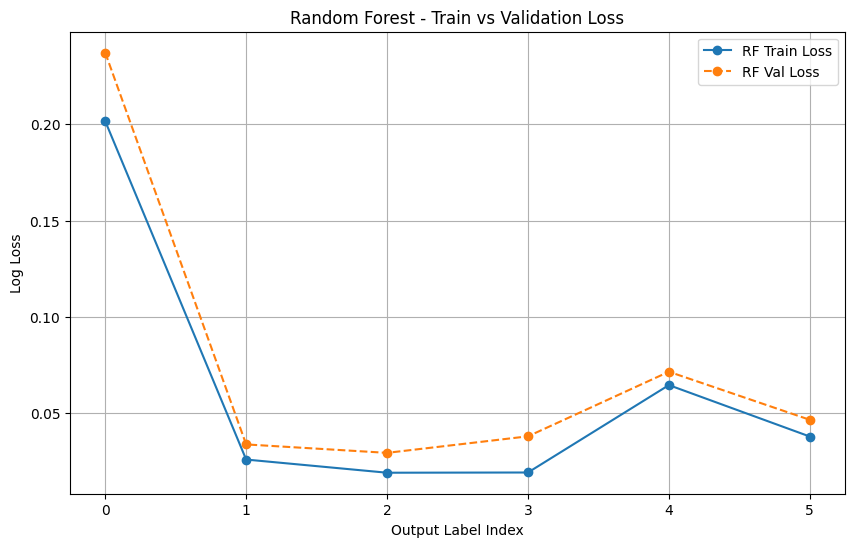

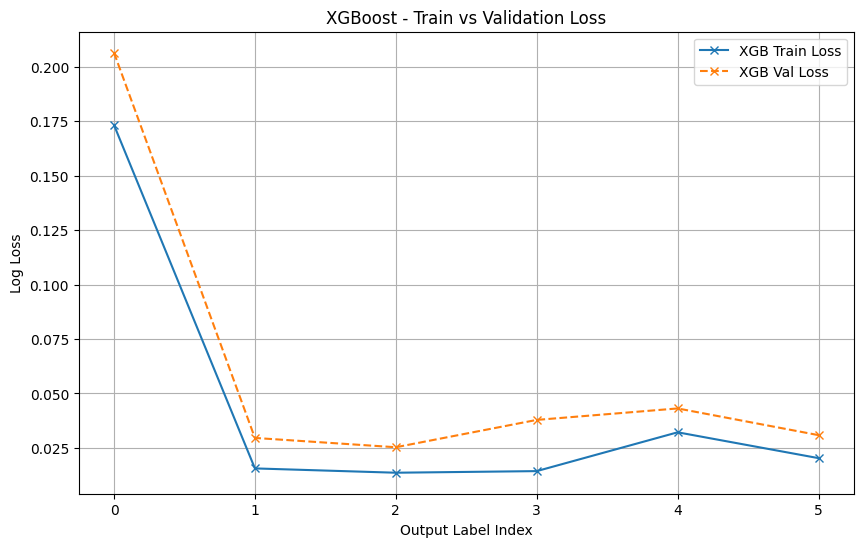

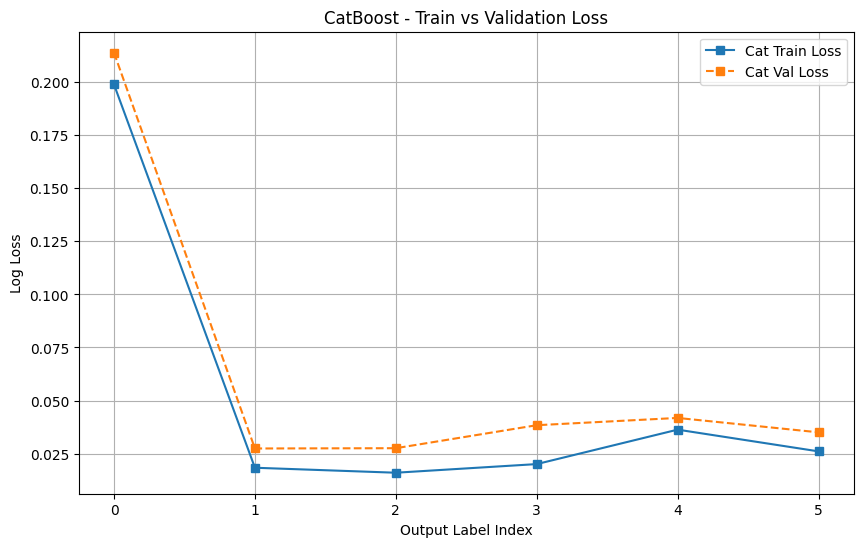

In [ ]:
# -------------------------------
# 6️⃣ Plot Train vs Validation Loss (Individually)
# -------------------------------
import matplotlib.pyplot as plt

# --- Plot for Random Forest ---
plt.figure(figsize=(10, 6))
plt.plot(rf_train_loss, label='RF Train Loss', marker='o', linestyle='-')
plt.plot(rf_val_loss, label='RF Val Loss', marker='o', linestyle='--')
plt.xlabel('Output Label Index')
plt.ylabel('Log Loss')
plt.title('Random Forest - Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('random_forest_loss.png')
plt.show()

# --- Plot for XGBoost ---
plt.figure(figsize=(10, 6))
plt.plot(xgb_train_loss, label='XGB Train Loss', marker='x', linestyle='-')
plt.plot(xgb_val_loss, label='XGB Val Loss', marker='x', linestyle='--')
plt.xlabel('Output Label Index')
plt.ylabel('Log Loss')
plt.title('XGBoost - Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('xgboost_loss.png')
plt.show()

# --- Plot for CatBoost ---
plt.figure(figsize=(10, 6))
plt.plot(cat_train_loss, label='Cat Train Loss', marker='s', linestyle='-')
plt.plot(cat_val_loss, label='Cat Val Loss', marker='s', linestyle='--')
plt.xlabel('Output Label Index')
plt.ylabel('Log Loss')
plt.title('CatBoost - Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('catboost_loss.png')
plt.show()

In [ ]:
# -------------------------------
# 7️⃣ Print Loss Values
# -------------------------------
print("--- Random Forest Losses ---")
print(f"Train Loss: {rf_train_loss}")
print(f"Validation Loss: {rf_val_loss}\n")

print("--- XGBoost Losses ---")
print(f"Train Loss: {xgb_train_loss}")
print(f"Validation Loss: {xgb_val_loss}\n")

print("--- CatBoost Losses ---")
print(f"Train Loss: {cat_train_loss}")
print(f"Validation Loss: {cat_val_loss}\n")

--- Random Forest Losses ---
Train Loss: [0.20148986209284, 0.026036752795241487, 0.019207464505092448, 0.019324446290582154, 0.06465427960771375, 0.03797494900921692]
Validation Loss: [0.2370277955625858, 0.03388377719242146, 0.029509620959633515, 0.03808364738347505, 0.07157970620240377, 0.04665269455192068]

--- XGBoost Losses ---
Train Loss: [0.17325766248197652, 0.015592302381014223, 0.013613142725974163, 0.014350831527134011, 0.032172761723410485, 0.020305424610417056]
Validation Loss: [0.20646545937970132, 0.029585277241966235, 0.025315763327528575, 0.0378645445247917, 0.04312849521746264, 0.03086694287198234]

--- CatBoost Losses ---
Train Loss: [0.19888632274705045, 0.018357412014684625, 0.016011828494405654, 0.02007735760062141, 0.036303166126752794, 0.026066609063056276]
Validation Loss: [0.2138511776933872, 0.027428593224025074, 0.027562759028025498, 0.03839353794805837, 0.04182105872666078, 0.03504036662067233]



Training RandomForest ...
RandomForest - Accuracy: 0.8991, MacroF1: 0.8891

Training XGBoost ...
XGBoost - Accuracy: 0.8862, MacroF1: 0.8771

Training CatBoost ...
CatBoost - Accuracy: 0.8734, MacroF1: 0.8638



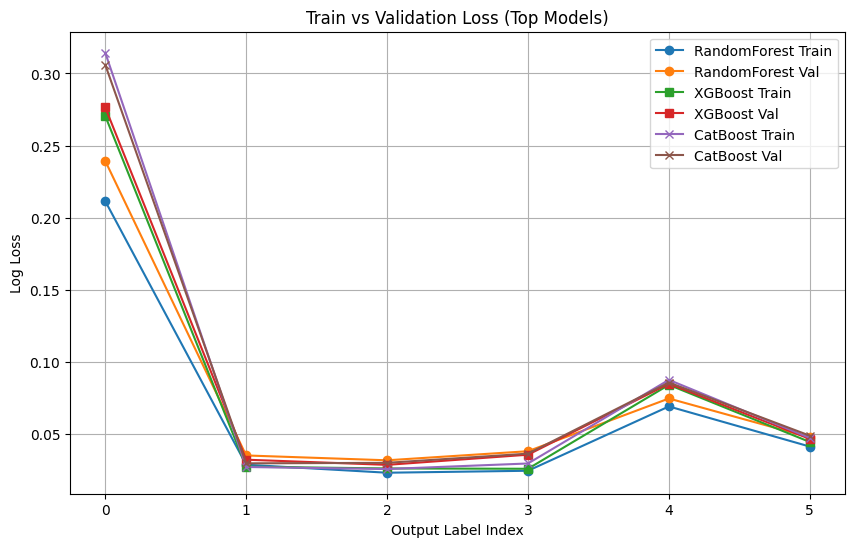

In [ ]:
# -------------------------------
models_config = {
    "RandomForest": {
        "model": RandomForestClassifier,
        "params": {"n_estimators":200, "max_depth":10, "min_samples_leaf":5, "random_state":42}
    },
    "XGBoost": {
        "model": XGBClassifier,
        "params": {"n_estimators":500, "max_depth":5, "learning_rate":0.01, 
                   "subsample":0.8, "colsample_bytree":0.8, "reg_alpha":0.1, 
                   "reg_lambda":1, "use_label_encoder":False, "eval_metric":"logloss", "random_state":42}
    },
    "CatBoost": {
        "model": CatBoostClassifier,
        "params": {"iterations":500, "depth":5, "learning_rate":0.01, 
                   "l2_leaf_reg":3, "subsample":0.8, "random_seed":42, "verbose":0}
    }
}

# -------------------------------
# 2️⃣ Storage
# -------------------------------
losses = {name: {"train":[], "val":[]} for name in models_config.keys()}
predictions = {name: [] for name in models_config.keys()}

# -------------------------------
# 3️⃣ Training loop
# -------------------------------
for name, cfg in models_config.items():
    print(f"Training {name} ...")
    model_class = cfg["model"]
    params = cfg["params"]
    
    model_list = []
    
    for i in range(y_train.shape[1]):  # Multi-output loop
        model = model_class(**params)
        model.fit(X_train, y_train.iloc[:, i])
        model_list.append(model)
        
        # Predict probabilities for log loss
        tr_pred = model.predict_proba(X_train)[:,1]
        val_pred = model.predict_proba(X_val)[:,1]
        
        # Store log loss
        losses[name]["train"].append(log_loss(y_train.iloc[:, i], tr_pred))
        losses[name]["val"].append(log_loss(y_val.iloc[:, i], val_pred))
    
    # Store predictions for evaluation
    preds_val = np.column_stack([m.predict(X_val) for m in model_list])
    predictions[name] = preds_val
    
    # Compute metrics
    acc = accuracy_score(y_val, preds_val)
    macro_f1 = f1_score(y_val, preds_val, average='macro')
    print(f"{name} - Accuracy: {acc:.4f}, MacroF1: {macro_f1:.4f}\n")

# -------------------------------
# 4️⃣ Plot train vs validation loss
# -------------------------------
plt.figure(figsize=(10,6))
markers = {"RandomForest":"o", "XGBoost":"s", "CatBoost":"x"}

for name in models_config.keys():
    plt.plot(losses[name]["train"], label=f'{name} Train', marker=markers[name])
    plt.plot(losses[name]["val"], label=f'{name} Val', marker=markers[name])

plt.xlabel("Output Label Index")
plt.ylabel("Log Loss")
plt.title("Train vs Validation Loss (Top Models)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

# 2️⃣ Hyperparameter grids
# -------------------------------

# Random Forest
rf_param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [None, 10, 20],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__max_features': ['auto', 'sqrt', 'log2']
}

# XGBoost
xgb_param_grid = {
    'estimator__n_estimators': [100, 300, 500],
    'estimator__max_depth': [3, 5, 6],
    'estimator__learning_rate': [0.01, 0.05, 0.1],
    'estimator__subsample': [0.7, 0.8, 1.0],
    'estimator__colsample_bytree': [0.7, 0.8, 1.0]
}

# CatBoost
cat_param_grid = {
    'estimator__iterations': [300, 500, 1000],
    'estimator__depth': [4, 6, 8],
    'estimator__learning_rate': [0.01, 0.05, 0.1],
    'estimator__l2_leaf_reg': [1, 3, 5],
    'estimator__border_count': [32, 64, 128]
}

# -------------------------------
# 3️⃣ Models
# -------------------------------
models = {
    'RandomForest': (MultiOutputClassifier(RandomForestClassifier(random_state=42)), rf_param_grid),
    'XGBoost': (MultiOutputClassifier(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)), xgb_param_grid),
    'CatBoost': (MultiOutputClassifier(CatBoostClassifier(verbose=0, random_state=42)), cat_param_grid)
}

# -------------------------------
# 4️⃣ Hyperparameter Tuning + Training
# -------------------------------
best_models = {}
for name, (model, param_grid) in models.items():
    print(f"--- Hyperparameter Tuning {name} ---")
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=10,
        scoring='f1_macro',
        cv=3,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_
    print(f"Best Params for {name}: {search.best_params_}\n")

# -------------------------------
# 5️⃣ Evaluation
# -------------------------------
for name, model in best_models.items():
    print(f"--- Evaluating {name} ---")
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    macro_f1 = f1_score(y_val, y_pred, average='macro')
    print(f"Accuracy: {acc:.4f} | Macro F1: {macro_f1:.4f}\n")


--- Hyperparameter Tuning RandomForest ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Params for RandomForest: {'estimator__n_estimators': 200, 'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 2, 'estimator__max_features': 'log2', 'estimator__max_depth': 20}

--- Hyperparameter Tuning XGBoost ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Params for XGBoost: {'estimator__subsample': 0.8, 'estimator__n_estimators': 500, 'estimator__max_depth': 5, 'estimator__learning_rate': 0.1, 'estimator__colsample_bytree': 1.0}

--- Hyperparameter Tuning CatBoost ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Params for CatBoost: {'estimator__learning_rate': 0.05, 'estimator__l2_leaf_reg': 5, 'estimator__iterations': 500, 'estimator__depth': 8, 'estimator__border_count': 128}

--- Evaluating RandomForest ---
Accuracy: 0.9425 | Macro F1: 0.9321

--- Evaluating XGBoost ---
Accuracy: 0.9369 | Macro F1: 0.9265

--- Eva

In [ ]:
# -------------------------------
# 1️⃣ Initialize tuned models
# -------------------------------
rf_models, xgb_models, cat_models = [], [], []

# Tuned params
rf_params = {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2'}
xgb_params = {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'use_label_encoder': False, 'eval_metric': 'logloss', 'random_state': 42}
cat_params = {'iterations': 500, 'depth': 8, 'learning_rate': 0.05, 'l2_leaf_reg': 5, 'border_count': 128, 'random_seed': 42, 'verbose': 0}

# Loss storage
rf_train_loss, rf_val_loss = [], []
xgb_train_loss, xgb_val_loss = [], []
cat_train_loss, cat_val_loss = [], []

# -------------------------------
# 2️⃣ Random Forest
# -------------------------------
for i in range(y_train.shape[1]):
    rf = RandomForestClassifier(**rf_params)
    rf.fit(X_train, y_train.iloc[:, i])
    rf_models.append(rf)
    
    tr_pred = rf.predict_proba(X_train)
    val_pred = rf.predict_proba(X_val)
    rf_train_loss.append(log_loss(y_train.iloc[:, i], tr_pred))
    rf_val_loss.append(log_loss(y_val.iloc[:, i], val_pred))

# -------------------------------
# 3️⃣ XGBoost
# -------------------------------
for i in range(y_train.shape[1]):
    xgb = XGBClassifier(**xgb_params)
    xgb.fit(X_train, y_train.iloc[:, i])
    xgb_models.append(xgb)
    
    tr_pred = xgb.predict_proba(X_train)
    val_pred = xgb.predict_proba(X_val)
    xgb_train_loss.append(log_loss(y_train.iloc[:, i], tr_pred))
    xgb_val_loss.append(log_loss(y_val.iloc[:, i], val_pred))

# -------------------------------
# 4️⃣ CatBoost
# -------------------------------
for i in range(y_train.shape[1]):
    cat = CatBoostClassifier(**cat_params)
    cat.fit(X_train, y_train.iloc[:, i])
    cat_models.append(cat)
    
    tr_pred = cat.predict_proba(X_train)
    val_pred = cat.predict_proba(X_val)
    cat_train_loss.append(log_loss(y_train.iloc[:, i], tr_pred))
    cat_val_loss.append(log_loss(y_val.iloc[:, i], val_pred))

# -------------------------------
# 5️⃣ Plot Train vs Validation Loss
# -------------------------------

# -------------------------------
# Random Forest Loss Plot
# -------------------------------
plt.figure(figsize=(8,5))
plt.plot(rf_train_loss, label='Train Loss', marker='o')
plt.plot(rf_val_loss, label='Validation Loss', marker='x')
plt.title('Random Forest - Train vs Validation Loss')
plt.xlabel('Output Label Index')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# XGBoost Loss Plot
# -------------------------------
plt.figure(figsize=(8,5))
plt.plot(xgb_train_loss, label='Train Loss', marker='o')
plt.plot(xgb_val_loss, label='Validation Loss', marker='x')
plt.title('XGBoost - Train vs Validation Loss')
plt.xlabel('Output Label Index')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# CatBoost Loss Plot
# -------------------------------
plt.figure(figsize=(8,5))
plt.plot(cat_train_loss, label='Train Loss', marker='o')
plt.plot(cat_val_loss, label='Validation Loss', marker='x')
plt.title('CatBoost - Train vs Validation Loss')
plt.xlabel('Output Label Index')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'y_train' is not defined